In [1]:
%load_ext autoreload
%autoreload 2

## AGN Variablity Metric \#1
This metric examines the number of visit at each location in the WFD area to ensure reliable fitting of CARMA models to AGN light curves generated. The minimum requirement is **60** epochs over the course of 10 years, and **100** epochs would be better. 

This notebook demonstrate how to run such a metric on opsims using the MAF for u band and g band observations. Redder filters are less concerned since they have much more observations than the u and g. The summary statistics I used to compare opsims are `FracAbove_60`, `FracAbove_100` and `Median`, the first two stand for the fraction of the WFD survey area that can be visited more 60 times and 100 times respectively. 

### 0. Software Setup

In [2]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

In [3]:
your_username = os.getcwd().split('/')[5]
print(f'Is your username "{your_username}"? If yes, nothing to worry about. If not, please mannually set your username!')

Is your username "ywx649999311"? If yes, nothing to worry about. If not, please mannually set your username!


**Import the sims_maf modules needed**

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [5]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

In [6]:
# import convenience functions
from opsimUtils import *

In [7]:
if your_username is None: # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = 'tmp/nVisit/ResultDBs/'
metricDataPath = 'tmp/nVisit/MetricData/'

root_dir = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput'
outDir = os.path.join(root_dir, outDir)
metricDataPath = os.path.join(root_dir, metricDataPath)

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

In [8]:
# check available opsim runs
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

In [9]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=dbRuns[0:5])

### 1. Declare some metrics to run on above OpSims

In [10]:
# nVisit Metric in U band
nVisitMetric = metrics.CountMetric('observationStartMJD', metricName='nVisitU')
nVisitSlicer = slicers.HealpixSlicer(nside=64)
nVisitUConstraint = 'filter = "u"'
nVisitUConstraint += ' and note not like "DD%"'

nVisitU = metricBundles.MetricBundle(nVisitMetric, nVisitSlicer, \
                nVisitUConstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
# nVisit Metric in g band
nVisitMetric = metrics.CountMetric('observationStartMJD', metricName='nVisitG')
nVisitSlicer = slicers.HealpixSlicer(nside=64)
nVisitGConstraint = 'filter = "g"'
nVisitGConstraint += ' and note not like "DD%"'

nVisitG = metricBundles.MetricBundle(nVisitMetric, nVisitSlicer, \
                nVisitGConstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [12]:
# set summary statistics
summaryMetrics = [metrics.FracAboveMetric(cutoff=60, metricName='FracAbove_60'),
                  metrics.FracAboveMetric(cutoff=100, metricName='FracAbove_100'),
                  metrics.MedianMetric()]
nVisitU.setSummaryMetrics(summaryMetrics)
nVisitG.setSummaryMetrics(summaryMetrics)

In [13]:
# create a bundleDict for all metrics to run on each opSim
bundleDict = {'nVisitU': nVisitU, 'nVisitG': nVisitG}

### 2. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

In [14]:
# below I am only going to run metrics on the first five opsims
for run in dbRuns[0:5]:
    # must set run name for each opSim to store metric data into
    # separate files
    print(f'Running metrics on: {run}')
    print('*************************************')
    nVisitU.setRunName(run)
    nVisitG.setRunName(run)
    metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
                    opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
    metricGroup.runAll()

Running metrics on: dcr_nham1_ugri_v1.5_10yrs
*************************************
Running metrics on: rolling_mod6_sdf_0.20_v1.5_10yrs
*************************************
Running metrics on: wfd_depth_scale0.95_noddf_v1.5_10yrs
*************************************
Running metrics on: u60_v1.5_10yrs
*************************************
Running metrics on: footprint_stuck_rollingv1.5_10yrs
*************************************


### 3. Now Visualize Summary Stat

In [15]:
# show avaiable summary
getSummaryStatNames(resultDbs[dbRuns[0]], 'nVisitG')

[{'metricId': 1, 'StatNames': ['FracAbove_100', 'FracAbove_60', 'Median']}]

#### 3.1 Nvisit in U band

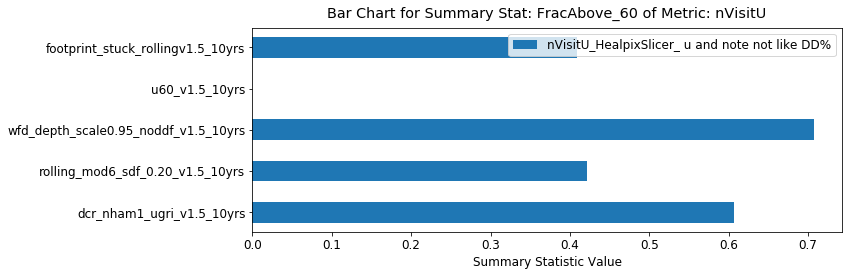

In [16]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitU', 'FracAbove_60', runNames=dbRuns[0:5])

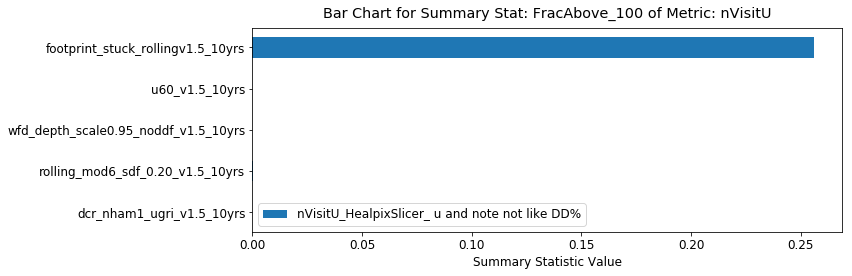

In [17]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitU', 'FracAbove_100', runNames=dbRuns[0:5])

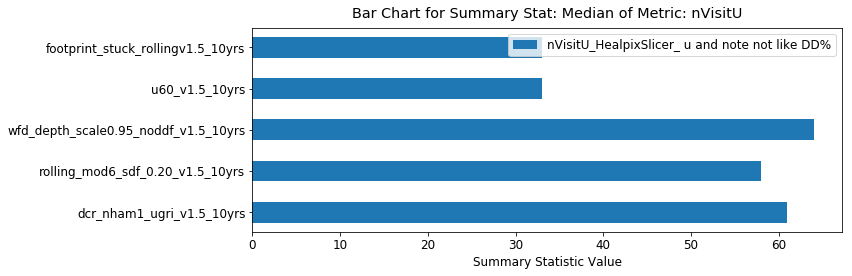

In [18]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitU', 'Median', runNames=dbRuns[0:5])

#### 3.2 Nvisit in g band

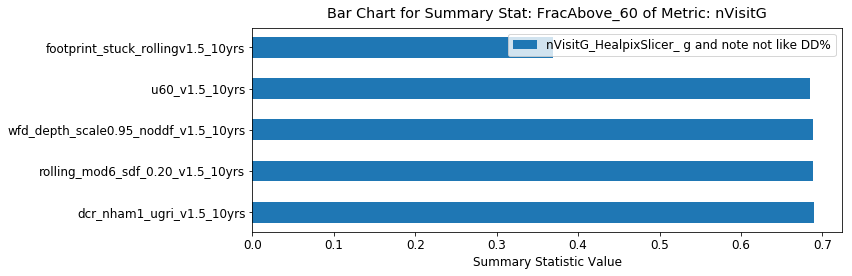

In [19]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitG', 'FracAbove_60', runNames=dbRuns[0:5])

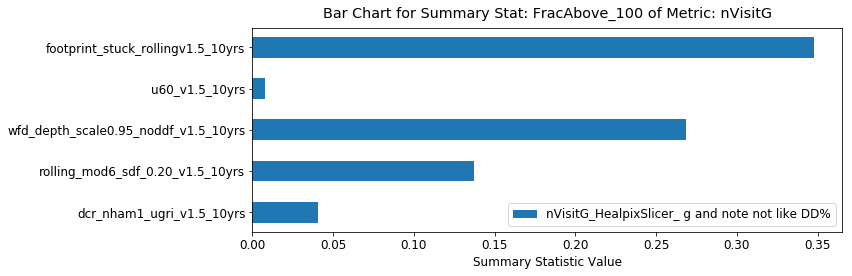

In [20]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitG', 'FracAbove_100', runNames=dbRuns[0:5])

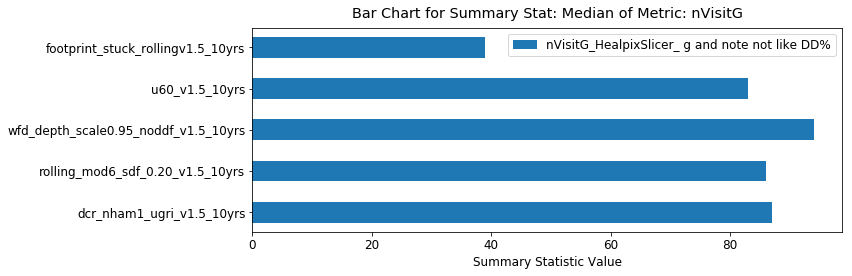

In [22]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitG', 'Median', runNames=dbRuns[0:5])